In [1]:
import warnings

import numpy as np
from ConfigSpace import (
    BetaIntegerHyperparameter,
    CategoricalHyperparameter,
    Configuration,
    ConfigurationSpace,
    NormalFloatHyperparameter,
    UniformIntegerHyperparameter,
    UniformFloatHyperparameter,
)
from sklearn.datasets import load_digits
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from smac.callback import Callback
from smac import HyperparameterOptimizationFacade, Scenario
from dynabo.smac_additions.dynmaic_prior_activation_function import (
    DynamicPriorAcquisitionFunction,
)
from smac.main.smbo import SMBO
from smac.runhistory import TrialInfo, TrialValue
from dynabo.smac_additions.local_and_prior_search import LocalAndPriorSearch
from dynabo.smac_additions.prior_random_search import PriorRandomSearch
import matplotlib.pyplot as plt

digits = load_digits()

In [2]:
class StopCallback(Callback):
    def __init__(self, stop_after: int):
        self._stop_after = stop_after

    def on_tell_end(self, smbo: SMBO, info: TrialInfo, value: TrialValue) -> bool | None:
        """Called after the stats are updated and the trial is added to the runhistory. Optionally, returns false
        to gracefully stop the optimization.
        """
        if smbo.runhistory.finished == self._stop_after:
            return False

        return None


class MLP:
    @property
    def prior_configspace(self) -> ConfigurationSpace:
        # Build Configuration Space which defines all parameters and their ranges.
        # To illustrate different parameter types,
        # we use continuous, integer and categorical parameters.
        cs = ConfigurationSpace()

        # We do not have an educated belief on the number of layers beforehand
        # As such, the prior on the HP is uniform
        n_layer = UniformIntegerHyperparameter(
            "n_layer",
            lower=1,
            upper=5,
        )

        # We believe the optimal network is likely going to be relatively wide,
        # And place a Beta Prior skewed towards wider networks in log space
        n_neurons = BetaIntegerHyperparameter(
            "n_neurons",
            lower=8,
            upper=256,
            alpha=4,
            beta=2,
            log=True,
        )

        # We believe that ReLU is likely going to be the optimal activation function about
        # 60% of the time, and thus place weight on that accordingly
        activation = CategoricalHyperparameter(
            "activation",
            ["logistic", "tanh", "relu"],
            weights=[1, 1, 3],
            default_value="relu",
        )

        # Moreover, we believe ADAM is the most likely optimizer
        optimizer = CategoricalHyperparameter(
            "optimizer",
            ["sgd", "adam"],
            weights=[0.1, 2],
            default_value="adam",
        )

        # We do not have an educated opinion on the batch size, and thus leave it as-is
        batch_size = UniformIntegerHyperparameter(
            "batch_size",
            16,
            512,
            default_value=128,
        )

        # We place a log-normal prior on the learning rate, so that it is centered on 10^-3,
        # with one unit of standard deviation per multiple of 10 (in log space)
        learning_rate_init = NormalFloatHyperparameter(
            "learning_rate_init",
            lower=1e-5,
            upper=1.0,
            mu=1e-3,  # will be transformed to log space later
            sigma=10,  # will be transformed to log space later
            log=True,
        )

        # Add all hyperparameters at once:
        cs.add([n_layer, n_neurons, activation, optimizer, batch_size, learning_rate_init])

        return cs

    @property
    def configspace(self) -> ConfigurationSpace:
        # Build Configuration Space which defines all parameters and their ranges.
        # To illustrate different parameter types,
        # we use continuous, integer and categorical parameters.
        cs = ConfigurationSpace()

        # We do not have an educated belief on the number of layers beforehand
        n_layer = UniformIntegerHyperparameter(
            "n_layer",
            lower=1,
            upper=5,
        )

        # Define network width without a specific prior
        n_neurons = UniformIntegerHyperparameter(
            "n_neurons",
            lower=8,
            upper=256,
        )

        # Define activation functions without specific weights
        activation = CategoricalHyperparameter(
            "activation",
            ["logistic", "tanh", "relu"],
            default_value="relu",
        )

        # Define optimizer without specific weights
        optimizer = CategoricalHyperparameter(
            "optimizer",
            ["sgd", "adam"],
            default_value="adam",
        )

        # Define batch size without specific distribution
        batch_size = UniformIntegerHyperparameter(
            "batch_size",
            16,
            512,
            default_value=128,
        )

        # Define learning rate range without log-normal prior
        learning_rate_init = UniformFloatHyperparameter(
            "learning_rate_init",
            lower=1e-5,
            upper=1.0,
            default_value=1e-3,
        )

        # Add all hyperparameters at once:
        cs.add([n_layer, n_neurons, activation, optimizer, batch_size, learning_rate_init])

        return cs

    def train(self, config: Configuration, seed: int = 0) -> float:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)

            classifier = MLPClassifier(
                hidden_layer_sizes=[config["n_neurons"]] * config["n_layer"],
                solver=config["optimizer"],
                batch_size=config["batch_size"],
                activation=config["activation"],
                learning_rate_init=config["learning_rate_init"],
                random_state=seed,
                max_iter=5,
            )

            # Returns the 5-fold cross validation accuracy
            cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)  # to make CV splits consistent
            score = cross_val_score(classifier, digits.data, digits.target, cv=cv, error_score="raise")

        return 1 - np.mean(score)

In [3]:
mlp = MLP()
default_config = mlp.configspace.get_default_configuration()

# Define our environment variables
scenario = Scenario(mlp.configspace, n_trials=40)

# We define the prior acquisition function, which conduct the optimization using priors over the optimum
acquisition_function = DynamicPriorAcquisitionFunction(
    acquisition_function=HyperparameterOptimizationFacade.get_acquisition_function(scenario),
    prior_configspace=mlp.configspace,
    decay_beta=scenario.n_trials / 10,  # Proven solid value
)

# We only want one config call (use only one seed in this example)
intensifier = HyperparameterOptimizationFacade.get_intensifier(
    scenario,
    max_config_calls=1,
)
stop_after = 20

# Create our SMAC object and pass the scenario and the train method
smac = HyperparameterOptimizationFacade(
    scenario,
    mlp.train,
    acquisition_function=acquisition_function,
    acquisition_maximizer=LocalAndPriorSearch(
        configspace=mlp.configspace,
        prior_configspace=mlp.prior_configspace,
        acquisition_function=acquisition_function,
    ),
    intensifier=intensifier,
    callbacks=[StopCallback(stop_after=stop_after)],
    overwrite=True,
)

[INFO][abstract_initial_design.py:87] Reducing the number of initial configurations from 60 to 10 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:139] Using 10 initial design configurations and 0 additional configurations.
[WARNING][prior_acquisition_function.py:114] Discretizing the prior for random forest models.


In [4]:
prior_random_search: PriorRandomSearch = smac._acquisition_maximizer._random_search
random_search_configs = prior_random_search._maximize(list(range(20)), 200)

In [5]:
smac2 = HyperparameterOptimizationFacade(
    scenario,
    mlp.train,
    acquisition_function=acquisition_function,
    acquisition_maximizer=LocalAndPriorSearch(
        configspace=mlp.configspace,
        prior_configspace=mlp.prior_configspace,
        acquisition_function=acquisition_function,
    ),
    intensifier=intensifier,
    overwrite=False,
)
smac2._acquisition_maximizer.dynamic_init(
    prior_configspace=mlp.prior_configspace,
)

smac2._acquisition_function.dynamic_init(
    smac._acquisition_function._acquisition_function,
    scenario.n_trials / 10,
    mlp.prior_configspace,
)

[INFO][abstract_initial_design.py:87] Reducing the number of initial configurations from 60 to 10 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:139] Using 10 initial design configurations and 0 additional configurations.
[INFO][smbo.py:509] Continuing from previous run.
[INFO][smbo.py:517] Since the previous run was not successful, SMAC will start from scratch again.


In [6]:
prior_random_search_configs = smac2._acquisition_maximizer._random_search._maximize(list(range(20)), 200)

In [7]:
mlp.configspace.keys()

KeysView(Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {logistic, tanh, relu}, Default: relu
    batch_size, Type: UniformInteger, Range: [16, 512], Default: 128
    learning_rate_init, Type: UniformFloat, Range: [1e-05, 1.0], Default: 0.001
    n_layer, Type: UniformInteger, Range: [1, 5], Default: 3
    n_neurons, Type: UniformInteger, Range: [8, 256], Default: 132
    optimizer, Type: Categorical, Choices: {sgd, adam}, Default: adam
)

In [8]:
from ConfigSpace.hyperparameters import NumericalHyperparameter

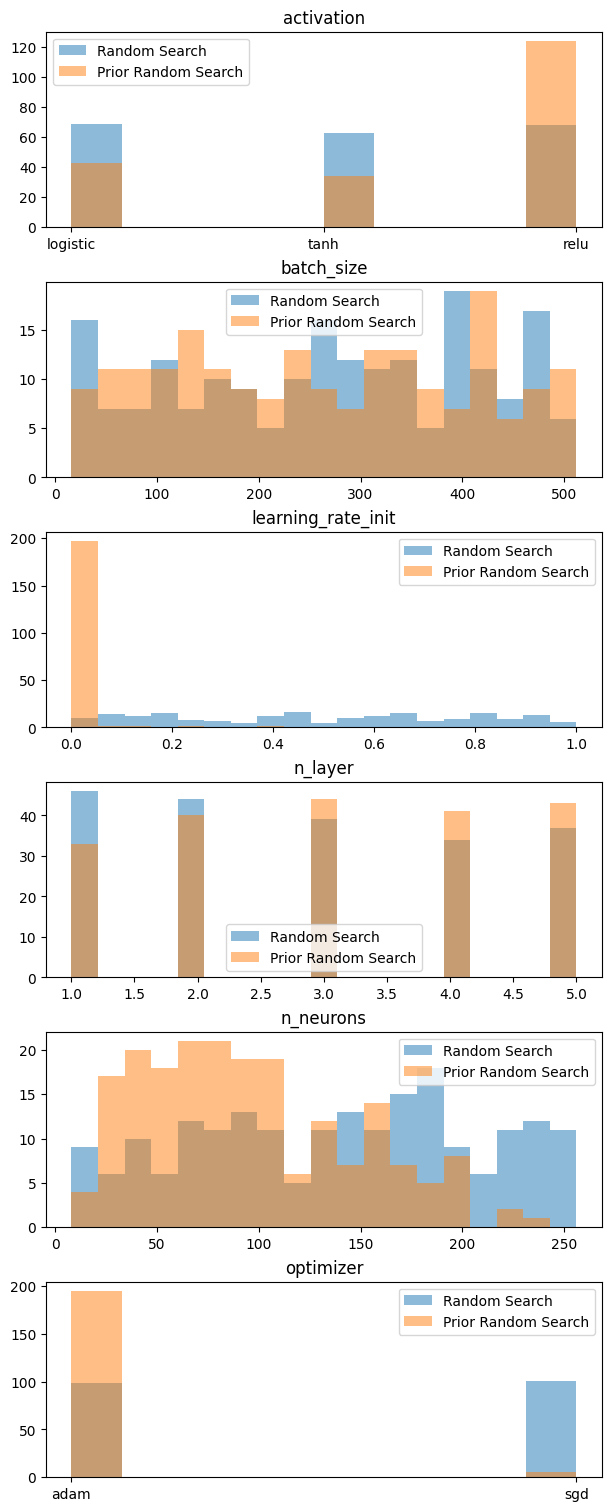

In [9]:
fig, axes = plt.subplots(len(mlp.configspace), 1, figsize=(6, 15), constrained_layout=True)

for index, hyperparameter in enumerate(mlp.configspace.values()):
    ax = axes[index]
    hyperparameter_name = hyperparameter.name
    if isinstance(hyperparameter, NumericalHyperparameter):
        random_configs = [config[1][hyperparameter_name] for config in random_search_configs]
        prior_random_configs = [config[1][hyperparameter_name] for config in prior_random_search_configs]

        # Bin the values into 5 bins
        bins = np.linspace(hyperparameter.lower, hyperparameter.upper, 20)
        ax.hist(random_configs, bins=bins, alpha=0.5, label="Random Search")
        ax.hist(prior_random_configs, bins=bins, alpha=0.5, label="Prior Random Search")
        ax.legend()
        ax.set_title(hyperparameter_name)
    else:
        ax.set_title(hyperparameter_name)
        ax.hist(
            [config[1][hyperparameter_name] for config in random_search_configs],
            alpha=0.5,
            label="Random Search",
        )
        ax.hist(
            [config[1][hyperparameter_name] for config in prior_random_search_configs],
            alpha=0.5,
            label="Prior Random Search",
        )
        ax.legend()